After exploring the quality of the model before, this dataframe makes the model directly

In [79]:
training_state_ids = [
    5842349984841728, # Initial 50 or so column cells
    6248348847702016, # Two additional L5 cells,
    4757235234242560, # Several cells with no detected apical that should have them
]

In [80]:
import bitsandbobs as bab
import json
import os
from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import tqdm
import pcg_skel
import joblib

from loguru import logger
logger.add('apical_labels.log')

from common_setup import project_paths, project_info
import sys
sys.path.append('src/')
from apical_model_utils import generate_nrn_df, process_apical_features, BranchClassifierFactory

mw_dir = f'{project_paths.skeletons}/skeleton_files'
cache_file = f'{project_paths.data}/l2lookup.sqlite'

training_skeleton_dir = bab.assert_dir('training_skeletons')
model_dir = 'models'

datastack = 'minnie65_phase3_v1'
voxel_resolution = np.array([4,4,40])

client = CAVEclient(datastack)

In [81]:
for state_id in training_state_ids:
    print(f'Neuroglancer link: {client.state.build_neuroglancer_url(state_id, "https://neuromancer-seung-import.appspot.com/")}')

Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/5842349984841728
Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/6248348847702016
Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/4757235234242560


In [82]:
nrn_df_fn = f'{training_skeleton_dir}/point_df_v{client.materialize.version}_{"_".join([str(x) for x in np.sort(training_state_ids)])}.feather'

if os.path.exists(nrn_df_fn):
    nrn_df = pd.read_feather(nrn_df_fn)
else:
    nrn_df = generate_nrn_df(training_state_ids, client, voxel_resolution = voxel_resolution)
    nrn_df.reset_index(drop=True).to_feather(nrn_df_fn)

Download all relevent skeletons and assign manual apical labels

In [83]:
oids = np.unique(nrn_df['root_id_curr'])

for oid in tqdm.tqdm(oids):
    spec_df = nrn_df.query('root_id_curr == @oid')
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    skel_file_training = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    
    if os.path.exists(skel_file_training):
        continue

    if os.path.exists(skel_file):
        logger.info(f'Loading {oid} from file')
        nrn = meshwork.load_meshwork(skel_file)
    else:
        logger.info(f'Loading {oid} from pcg_skel')
        soma_df = client.materialize.query_table('nucleus_detection_v0',
                                                 filter_equal_dict={
                                                     'pt_root_id': oid,
                                                 })
        soma_pt = soma_df.iloc[0]['pt_position'].squeeze()

        nrn = pcg_skel.pcg_meshwork(oid,
                                    client=client,
                                    collapse_soma=True,
                                    refine='all',
                                    synapse_table=project_info.synapse_table,
                                    synapses='all',
                                    root_point=soma_pt,
                                    root_point_resolution=[4,4,40],
                                    cache=cache_file,
                                    save_to_cache=True,
                                    segmentation_fallback=False,
                                    n_parallel=8)

    if "is_axon" not in nrn.anno.table_names:
        logger.info(f'Computing axon for {oid}')
        if len(nrn.anno.pre_syn) > 0 and len(nrn.anno.post_syn) > 0:
            is_axon, split_quality = meshwork.algorithms.split_axon_by_synapses(
                nrn, nrn.anno.pre_syn.mesh_index, nrn.anno.post_syn.mesh_index
            )
        else:
            split_quality = -1
            is_axon = []
        nrn.anno.add_annotations("is_axon", is_axon, mask=True)

    logger.info(f'Processing apical points for {oid}')
    ap_pts = np.vstack(nrn_df.query(f'root_id_curr == @oid',
                   engine='python')['pt_vx'].values)

    ap_l2ids = nrn_df.query('root_id_curr == @oid', engine='python')['l2id'].values
    ap_minds = nrn.anno.lvl2_ids.df.query('lvl2_id in @ap_l2ids')['mesh_ind'].values

    all_apical = []
    for ap_mind in ap_minds:
        ptr = nrn.path_between(ap_mind, nrn.root, return_as_skel=True)
        ptr_nr = ptr[ptr!=nrn.skeleton.root]
        if len(ptr_nr) > 0:
            apical_pts = nrn.downstream_of(ptr_nr[[0]])
            all_apical.append(apical_pts[0].to_skel_index)
    all_apical = np.unique(np.concatenate(all_apical))
    
    try:
        nrn.anno.remove_annotations('is_apical')
    except:
        pass

    nrn.anno.add_annotations('is_apical', nrn.SkeletonIndex(all_apical).to_mesh_index, mask=True)
    nrn.save_meshwork(skel_file_training, overwrite=True)

  0%|          | 0/83 [00:00<?, ?it/s]2021-10-14 15:54:31.077 | INFO     | __main__:<module>:15 - Loading 864691135274448101 from pcg_skel

100%|██████████| 3942/3942 [00:00<00:00, 46378.27it/s]
2021-10-14 15:54:58.272 | INFO     | __main__:<module>:36 - Computing axon for 864691135274448101
2021-10-14 15:54:58.345 | INFO     | __main__:<module>:46 - Processing apical points for 864691135274448101
  8%|▊         | 7/83 [00:27<04:57,  3.91s/it]2021-10-14 15:54:58.459 | INFO     | __main__:<module>:15 - Loading 864691135355207375 from pcg_skel

100%|██████████| 4827/4827 [00:00<00:00, 35161.47it/s]
2021-10-14 15:55:36.835 | INFO     | __main__:<module>:36 - Computing axon for 864691135355207375
2021-10-14 15:55:36.959 | INFO     | __main__:<module>:46 - Processing apical points for 864691135355207375
 13%|█▎        | 11/83 [01:06<07:48,  6.50s/it]2021-10-14 15:55:37.166 | INFO     | __main__:<module>:15 - Loading 864691135394257141 from pcg_skel

100%|██████████| 4592/4592 [00:00<00:00, 

Apply apical labels as annotations to all the files

---

In [6]:
skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
nrn = meshwork.load_meshwork(skel_file)

ap_pts = np.vstack(nrn_df.query(f'root_id_curr == @oid',
                   engine='python')['pt_vx'].values)

In [7]:
ap_l2ids = nrn_df.query('root_id_curr == @oid', engine='python')['l2id'].values
ap_minds = nrn.anno.lvl2_ids.df.query('lvl2_id in @ap_l2ids')['mesh_ind'].values

all_apical = []


In [8]:
for ap_mind in ap_minds:
    ptr = nrn.path_between(ap_minds[0], nrn.root, return_as_skel=True)
    ptr_nr = ptr[ptr!=nrn.skeleton.root]
    if len(ptr_nr) > 0:
        apical_pts = nrn.downstream_of(ptr_nr[[0]])
        all_apical.append(apical_pts[0].to_skel_index)

In [9]:
for oid in tqdm.tqdm(np.unique(nrn_df['root_id_curr'])):
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    nrn = meshwork.load_meshwork(skel_file)
    
    ap_pts = np.vstack(nrn_df.query(f'root_id_curr == @oid',
                       engine='python')['pt_vx'].values)

    ap_l2ids = nrn_df.query('root_id_curr == @oid', engine='python')['l2id'].values

    ap_minds = nrn.anno.lvl2_ids.df.query('lvl2_id in @ap_l2ids')['mesh_ind'].values

    all_apical = []
    for ap_mind in ap_minds:
        ptr = nrn.path_between(ap_mind, nrn.root, return_as_skel=True)
        ptr_nr = ptr[ptr!=nrn.skeleton.root]
        if len(ptr_nr) > 0:
            apical_pts = nrn.downstream_of(ptr_nr[[0]])
            all_apical.append(apical_pts[0].to_skel_index)
    all_apical = np.unique(np.concatenate(all_apical))
    nrn.anno.remove_annotations('is_apical')
    nrn.anno.add_annotations('is_apical', nrn.SkeletonIndex(all_apical).to_mesh_index, mask=True)
    nrn.save_meshwork(skel_file, overwrite=True)

  2%|▏         | 1/64 [00:00<00:15,  4.14it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691134884871930_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135162310957_with_apical.h5...


  5%|▍         | 3/64 [00:00<00:12,  4.86it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135181977858_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135233295705_with_apical.h5...


  8%|▊         | 5/64 [00:01<00:13,  4.27it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135274322149_with_apical.h5...


  9%|▉         | 6/64 [00:01<00:12,  4.71it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135274334181_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135278398625_with_apical.h5...


 12%|█▎        | 8/64 [00:01<00:10,  5.18it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135334693097_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135345425311_with_apical.h5...


 17%|█▋        | 11/64 [00:02<00:08,  5.97it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135358807384_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135367351801_with_apical.h5...


 19%|█▉        | 12/64 [00:02<00:09,  5.61it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135382620122_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135382723290_with_apical.h5...


 22%|██▏       | 14/64 [00:02<00:10,  4.61it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135394166773_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135396555809_with_apical.h5...


 25%|██▌       | 16/64 [00:03<00:09,  4.91it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135407449033_with_apical.h5...


 28%|██▊       | 18/64 [00:03<00:08,  5.50it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135428664368_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135445835922_with_apical.h5...


 30%|██▉       | 19/64 [00:03<00:08,  5.33it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135478396358_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135501692226_with_apical.h5...


 33%|███▎      | 21/64 [00:04<00:07,  5.51it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135502247093_with_apical.h5...


 34%|███▍      | 22/64 [00:04<00:08,  4.73it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135516059091_with_apical.h5...


 36%|███▌      | 23/64 [00:04<00:08,  5.05it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135517695626_with_apical.h5...


 38%|███▊      | 24/64 [00:04<00:08,  4.62it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135560494305_with_apical.h5...


 39%|███▉      | 25/64 [00:04<00:08,  4.72it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135564761879_with_apical.h5...


 41%|████      | 26/64 [00:05<00:08,  4.44it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135569046918_with_apical.h5...


 42%|████▏     | 27/64 [00:05<00:08,  4.39it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135571024365_with_apical.h5...


 44%|████▍     | 28/64 [00:05<00:10,  3.48it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135576996357_with_apical.h5...


 45%|████▌     | 29/64 [00:06<00:09,  3.64it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135581747053_with_apical.h5...


 47%|████▋     | 30/64 [00:06<00:08,  3.90it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135585980356_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135590140683_with_apical.h5...


 50%|█████     | 32/64 [00:06<00:07,  4.12it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135614152907_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135696154522_with_apical.h5...


 53%|█████▎    | 34/64 [00:07<00:06,  4.55it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135715389722_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135737790577_with_apical.h5...


 56%|█████▋    | 36/64 [00:07<00:04,  5.71it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135748884521_with_apical.h5...


 58%|█████▊    | 37/64 [00:07<00:06,  3.90it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135754980562_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135776101293_with_apical.h5...


 61%|██████    | 39/64 [00:08<00:05,  4.45it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135782638387_with_apical.h5...


 62%|██████▎   | 40/64 [00:08<00:05,  4.56it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135841236451_with_apical.h5...


 64%|██████▍   | 41/64 [00:08<00:05,  4.05it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135909953193_with_apical.h5...


 66%|██████▌   | 42/64 [00:08<00:05,  4.39it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135925745422_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135941293428_with_apical.h5...


 69%|██████▉   | 44/64 [00:09<00:04,  4.76it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135952133155_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135974646895_with_apical.h5...


 72%|███████▏  | 46/64 [00:09<00:03,  4.94it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691135975686467_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136020517624_with_apical.h5...


 75%|███████▌  | 48/64 [00:10<00:02,  5.44it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136031895483_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136065632920_with_apical.h5...


 78%|███████▊  | 50/64 [00:10<00:02,  5.57it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136089203255_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136143686452_with_apical.h5...


 81%|████████▏ | 52/64 [00:10<00:02,  5.58it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136143686708_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136175405318_with_apical.h5...


 84%|████████▍ | 54/64 [00:11<00:02,  4.98it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136266561524_with_apical.h5...


 88%|████████▊ | 56/64 [00:11<00:01,  5.10it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136266672884_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136286604995_with_apical.h5...


 89%|████████▉ | 57/64 [00:11<00:01,  5.14it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136296910107_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136329195754_with_apical.h5...


 92%|█████████▏| 59/64 [00:12<00:00,  5.51it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136379077077_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136672967303_with_apical.h5...


 95%|█████████▌| 61/64 [00:12<00:00,  6.23it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136952134623_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691136973935900_with_apical.h5...


 98%|█████████▊| 63/64 [00:12<00:00,  5.43it/s]

	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691137019791726_with_apical.h5...
	Deleting existing data in /Users/caseys/Work/data_analysis/MinnieColumn/pipelines/apical_classification/training_skeletons/864691137197070913_with_apical.h5...


100%|██████████| 64/64 [00:13<00:00,  4.91it/s]


---
#### Extract synapses from training data and generate model

In [85]:
pt_feature_dfs = []
for oid in tqdm.tqdm(oids):
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    nrn = meshwork.load_meshwork(skel_file)
    nrn.reset_mask()
    point_features_df = process_apical_features(nrn)
    nrn.reset_mask()
    point_features_df['is_apical'] = nrn.anno.is_apical.mesh_index.to_skel_mask[point_features_df['v_skind_base']]
    pt_feature_dfs.append(point_features_df)

pt_feature_df = pd.concat(pt_feature_dfs)
del pt_feature_dfs

100%|██████████| 83/83 [02:19<00:00,  1.68s/it]


In [86]:
feature_cols = ['del_y',
                'del_r',
                'rho',
                'theta',
                'pt_y', 
                'dist_to_root',
                'dist_from_tip',
                'dist_to_root_rel',
                'tort',
                'bp_to_root']

In [87]:
pt_feature_df = pt_feature_df.reset_index(drop=True)

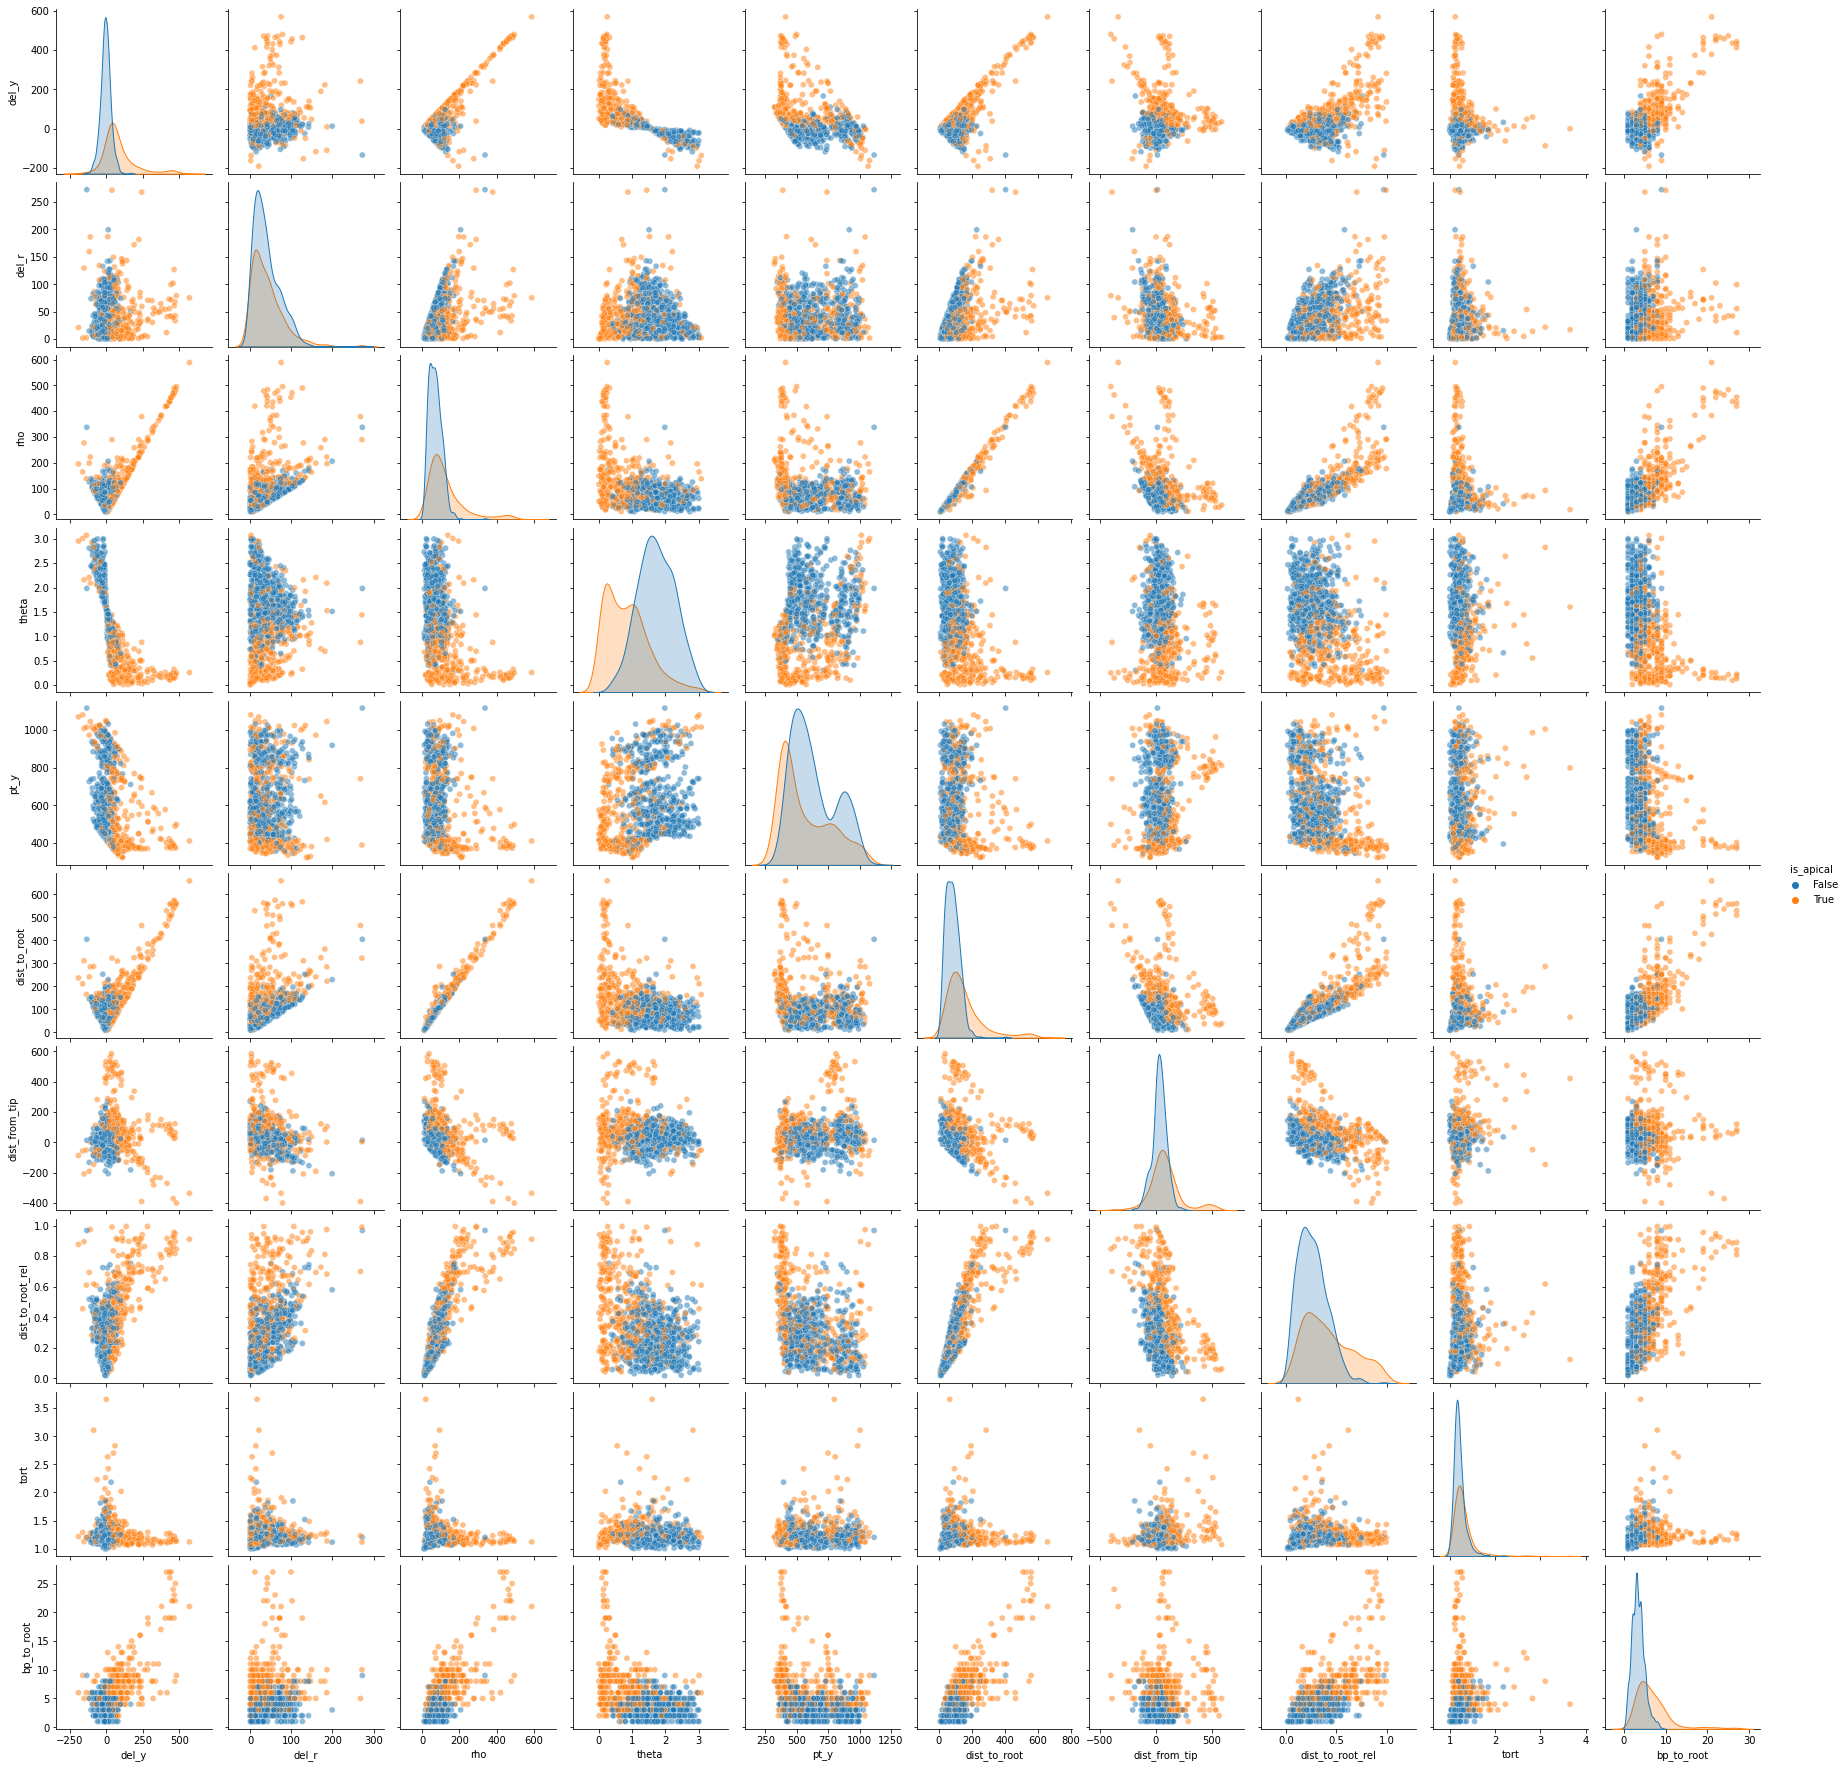

In [88]:
import seaborn as sns
sns.pairplot(pt_feature_df.sample(1000),
             vars=feature_cols,
             hue='is_apical',
             plot_kws=dict(alpha=0.5))

<module 'umap' from '/Users/caseys/opt/miniconda3/envs/analysis/lib/python3.8/site-packages/umap/__init__.py'>

In [100]:
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
import joblib

In [101]:
point_data = pt_feature_df[feature_cols].values
is_apical_all = pt_feature_df['is_apical']

In [102]:
smote = over_sampling.SMOTE()
X_res, y_res = smote.fit_resample(point_data, is_apical_all)
rfc = RandomForestClassifier(n_estimators=200,
                             max_features=4,
                             n_jobs=8,
                             )
rfc.fit(X_res, y_res)

RandomForestClassifier(max_features=4, n_estimators=200, n_jobs=8)

### Branch classifier

Currently somewhat ad-hoc, but principled. Treat the question like Bayesian model selection: Given the classifier results, is a branch more likely to be an apical or basal dendrite.

* Compute log-odds ratio for apical vs not-apical.
* Because points are not actually independent from one another, scale this down.
* Ignore branches that are too short to be an apical dendrite
* Neurons have between zero and a few apical dendrites, so use a softmax to declare a winner if the most "apicalish" dendrite is much more apical than others, but allow ties if several neurites are similarly "apicalish".
* Classify as apical branches that have both a positive log-odds ratio and are above a given softmax threshold.

In [103]:
branch_classifier_params = dict(min_length=50,
                                logodds_clip=100,
                                softmax_scaler=50,
                                bin_num=80,
                                logodds_thresh=0,
                                softmax_thresh=0.3)

In [104]:
classifier_fn = f'{model_dir}/point_model_current.pkl'
feature_cols_fn = f'{model_dir}/feature_cols_current.pkl'
branch_classifier_params_fn = f'{model_dir}/branch_params_current.pkl'

version_post = f'{client.materialize.version}_{"_".join([str(x) for x in np.sort(training_state_ids)])}'

classifier_specific_fn = f'{model_dir}/point_model_v{version_post}.pkl'
feature_cols_specific_fn = f'{model_dir}/feature_cols_v{version_post}.pkl'
branch_classifier_params_specific_fn = f'{model_dir}/branch_params_v{version_post}.pkl'

In [105]:
joblib.dump(rfc, classifier_fn)
joblib.dump(feature_cols, feature_cols_fn)
joblib.dump(branch_classifier_params, branch_classifier_params_fn)

joblib.dump(rfc, classifier_specific_fn)
joblib.dump(feature_cols, feature_cols_specific_fn)
joblib.dump(branch_classifier_params, branch_classifier_params_specific_fn)

['models/branch_params_v211_4757235234242560_5842349984841728_6248348847702016.pkl']

---

In [106]:
example_df = pt_feature_df.query('root_id != @oids[9]').reset_index(drop=True)
point_data = example_df[feature_cols].values
is_apical_all = example_df['is_apical']

X_res, y_res = smote.fit_resample(point_data, is_apical_all)
rfc = RandomForestClassifier(n_estimators=200,
                             max_features=4,
                             n_jobs=8,
                             )

rfc.fit(X_res, y_res)

RandomForestClassifier(max_features=4, n_estimators=200, n_jobs=8)

In [107]:
import matplotlib.pyplot as plt

In [108]:
ex_root_id = 864691136672967303

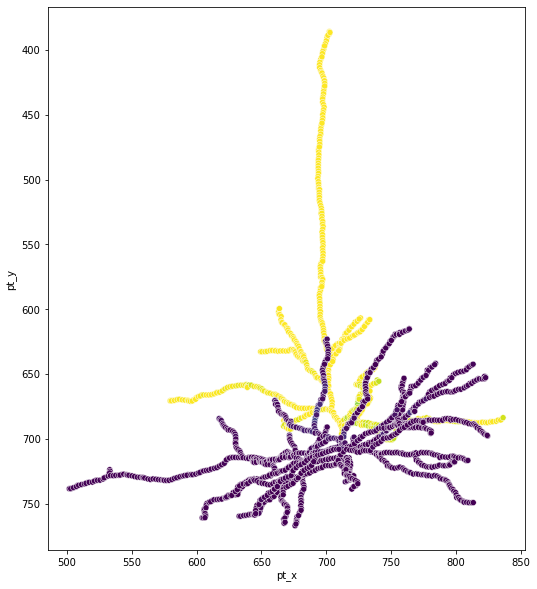

In [109]:
example_test_df = pt_feature_df.query('root_id == @ex_root_id').reset_index(drop=True)
example_test_df['prob_ap'] = rfc.predict_proba(example_test_df[feature_cols].values)[:,1]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='pt_x', y='pt_y', hue='prob_ap', data=example_test_df, palette='viridis', ax=ax, legend=False)
ax.invert_yaxis()
ax.set_aspect('equal')

In [76]:
BranchClassifier = BranchClassifierFactory(rfc, feature_cols)
branch_classifier = BranchClassifier(**branch_classifier_params)

In [77]:
df_test = pt_feature_df.query('root_id == @ex_root_id', engine='python').reset_index(drop=True)
df_test = df_test.rename(columns={'is_apical': 'is_apical_gt'})
branch_df = branch_classifier.fit_predict_data(df_test, 'base_skind')

In [78]:
branch_df

,base_skind,apical_prob,logodds_ratio,len_br,logodds_clipped,softmax_denom,softmax_num,apical_softmax,is_apical
0,1179,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1815.812934,116,-100.00000,8.336403,0.135335,0.016234,False
1,1182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1894.080733,121,-100.00000,8.336403,0.135335,0.016234,False
2,1203,"[0.98, 0.98, 1.0, 0.995, 1.0, 0.995, 0.97, 0.9...",1068.891626,644,100.00000,8.336403,7.389056,0.886360,True
3,1204,[0.005],-15.653560,1,-15.65356,8.336403,0.731198,0.087711,False
4,1210,"[0.005, 0.005, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4206.346393,393,-100.00000,8.336403,0.135335,0.016234,False
5,1239,"[0.035, 0.025, 0.07, 0.055, 0.14, 0.04, 0.03, ...",-1021.365375,77,-100.00000,8.336403,0.135335,0.016234,False
6,1244,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1518.395298,97,-100.00000,8.336403,0.135335,0.016234,False
7,1270,"[0.0, 0.0, 0.01, 0.01, 0.005, 0.0, 0.0, 0.01, ...",-1635.254162,108,-100.00000,8.336403,0.135335,0.016234,False
8,1271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01,...",-767.024429,49,-100.00000,8.336403,0.135335,0.016234,False
9,1272,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005...",-469.606793,30,-100.00000,8.336403,0.135335,0.016234,False


---

### Check the model with Leave-one-out analysis of the training data

In [111]:
loo_predictions = []
oids = np.unique(pt_feature_df['root_id'])
results = []
for oid in tqdm.tqdm(oids):
    df = pt_feature_df.query('root_id != @oid', engine='python').reset_index(drop=True)
    feat_data = df[feature_cols].values
    is_apical = df['is_apical'].values

    rfc = RandomForestClassifier(n_estimators=200,
                                 max_features=4,
                                 n_jobs=8,
                                 )
    rfc.fit(feat_data, is_apical)
    BranchClassifier = BranchClassifierFactory(rfc, feature_cols)
    branch_classifier = BranchClassifier(**branch_classifier_params)
    
    df_test = pt_feature_df.query('root_id == @oid', engine='python').reset_index(drop=True)
    df_test = df_test.rename(columns={'is_apical': 'is_apical_gt'})
    
    branch_df = branch_classifier.fit_predict_data(df_test, 'base_skind')
    branch_df['root_id'] = oid
    branch_df = branch_df.merge(df_test.groupby('base_skind').sample(1)[['base_skind', 'is_apical_gt']], on='base_skind')
    results.append(branch_df)
all_branch = pd.concat(results)

100%|██████████| 83/83 [38:06<00:00, 27.54s/it]


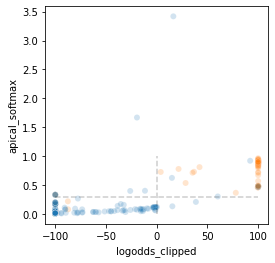

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(y='apical_softmax', x='logodds_clipped', hue='is_apical_gt', data=all_branch, alpha=0.2, legend=False) 
ax.plot((-100, 100), (0.3, 0.3), 'k--', alpha=0.2)
ax.plot((0,0), (0,1), 'k--', alpha=0.2)

In [113]:
all_branch.pivot_table(index='is_apical', columns='is_apical_gt', values='len_br', aggfunc=len)

is_apical_gt,False,True
is_apical,,
False,564,10
True,7,81


In [63]:
all_ids = np.unique(all_branch['root_id'])

In [69]:
found_ids = np.unique(all_branch.query('is_apical == True and is_apical_gt == False')['root_id'])

In [70]:
found_ids

array([864691135428664368, 864691135696154522])

In [50]:
all_branch.groupby(['is_apical', 'is_apical_gt'])[['root_id']].count().reset_index()

,is_apical,is_apical_gt,root_id
0,False,False,457
1,False,True,5
2,True,False,4
3,True,True,66


In [114]:
all_branch.query('is_apical_gt == False and is_apical == True')

,base_skind,apical_prob,logodds_ratio,len_br,logodds_clipped,softmax_denom,softmax_num,apical_softmax,is_apical,root_id,is_apical_gt
0,1097,"[0.135, 0.11, 0.11, 0.11, 0.105, 0.1, 0.12, 0....",256.415835,594,100.000000,15.590124,7.389056,0.473957,True,864691135428664368,False
3,975,"[0.46, 0.44, 0.45, 0.455, 0.45, 0.405, 0.425, ...",102.662110,287,100.000000,15.914049,7.389056,0.464310,True,864691135571324197,False
1,989,"[0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.8...",240.659931,409,100.000000,15.184118,7.389056,0.486631,True,864691135696154522,False
2,1170,"[0.295, 0.275, 0.32, 0.32, 0.31, 0.31, 0.295, ...",15.010184,361,15.010184,2.159837,1.350134,0.625109,True,864691135699470370,False
0,913,"[0.38, 0.37, 0.73, 0.375, 0.36, 0.735, 0.34, 0...",60.202191,460,60.202191,10.993297,3.333570,0.303237,True,864691135925745422,False
1,1691,"[0.815, 0.8, 0.815, 0.805, 0.825, 0.8, 0.81, 0...",92.087288,822,92.087288,6.848881,6.307540,0.920959,True,864691136008816302,False
4,1210,"[0.675, 0.67, 0.67, 0.66, 0.645, 0.66, 0.645, ...",234.111599,393,100.000000,15.590124,7.389056,0.473957,True,864691136672967303,False


In [115]:
all_branch.query('root_id == 864691136008816302')

,base_skind,apical_prob,logodds_ratio,len_br,logodds_clipped,softmax_denom,softmax_num,apical_softmax,is_apical,root_id,is_apical_gt
0,1642,"[0.045, 0.06, 0.03, 0.05, 0.06, 0.045, 0.015, ...",-947.966550,157,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,False
1,1691,"[0.815, 0.8, 0.815, 0.805, 0.825, 0.8, 0.81, 0...",92.087288,822,92.087288,6.848881,6.307540,0.920959,True,864691136008816302,False
2,1773,"[0.03, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-112.757048,9,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,False
3,1804,"[0.09, 0.085, 0.105, 0.105, 0.105, 0.115, 0.1,...",-38.651463,39,-38.651463,6.848881,0.461613,0.067400,False,864691136008816302,False
4,1805,"[0.07, 0.06, 0.05, 0.04, 0.045, 0.04, 0.035, 0...",-371.903987,214,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,False
5,1835,"[0.125, 0.075, 0.12, 0.095, 0.11, 0.115, 0.165...",-212.427037,42,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,False
6,1841,"[0.635, 0.61, 0.665, 0.675, 0.675, 0.66, 0.655...",-911.379936,447,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,True
7,1872,"[0.415, 0.415, 0.435, 0.445, 0.415, 0.425, 0.4...",-251.863535,380,-100.000000,6.848881,0.135335,0.019760,False,864691136008816302,False
